In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

In [4]:
from sklearn.feature_selection import RFE

In [5]:
from sklearn.compose import ColumnTransformer, make_column_selector, TransformedTargetRegressor
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer

In [6]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [7]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor

In [8]:
import joblib

In [9]:
from Utilities.Visualizer import Visualizer
from Utilities.LinRegDiagnostics import LinRegDiagnostics
from Utilities.ModelSaver import ModelSaver

# 1. Read data and get training set and test set

In [10]:
df = pd.read_csv('House Price/house-prices-advanced-regression-techniques/train.csv')
print(df.shape)
df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [11]:
df_Id = df.pop('Id')
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [12]:
X_train = df_train.drop('SalePrice', axis=1).reset_index(drop=True)
y_train = df_train['SalePrice'].reset_index(drop=True)

X_test = df_test.drop('SalePrice', axis=1).reset_index(drop=True)
y_test = df_test['SalePrice'].reset_index(drop=True)

In [13]:
X_train.shape

(1168, 79)

In [14]:
X_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1,60,RL,59.0,7837,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal
2,30,RL,67.0,8777,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,5,2008,WD,Normal
3,50,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,0,NaN,MnPrv,NaN,0,6,2007,WD,Normal
4,50,RL,50.0,5000,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,20,RL,78.0,9317,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,3,2007,WD,Normal
1164,50,RL,65.0,7804,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,12,2009,WD,Normal
1165,20,RL,60.0,8172,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Normal
1166,50,RL,55.0,7642,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,0,NaN,GdPrv,NaN,0,6,2007,WD,Normal


# 2. Preprocessing

In [15]:
X_train.dtypes.value_counts()

object     43
int64      33
float64     3
dtype: int64

## 2.1 Convert some categorical values to numerical values (similar to OrdinalEncoder)

In [16]:
cat2num_code = {
    'Utilities': {'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1},
    'LandSlope': {'Gtl': 3, 'Mod': 2, 'Sev': 1},
    'ExterQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'ExterCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0},
    'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0},
    'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, np.nan: 0},
    'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, np.nan: 0},
    'BsmtFinType2': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, np.nan: 0},
    'HeatingQC': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'CentralAir': {'Y': 1, 'N': 0},
    'Electrical': {'SBrkr': 5, 'FuseA': 4, 'FuseF': 3, 'FuseP': 2, 'Mix': 1},
    'KitchenQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'Functional': {'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5,
                   'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1},
    'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0},
    'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, np.nan: 0},
    'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0},
    'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0},
    'PavedDrive': {'Y': 2, 'P': 1, 'N': 0},
    'PoolQC': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, np.nan: 0},
    'Fence': {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, np.nan: 0},
}

In [17]:
class Cat2NumTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X: pd.DataFrame):
        X = X.replace(cat2num_code)
        cats = list(cat2num_code.keys())
        X[cats] = X[cats].astype(np.float64)
        return X

In [18]:
X_train_cat2num = Cat2NumTransformer().fit_transform(X_train)
X_train_cat2num.dtypes.value_counts()

int64      33
float64    24
object     22
dtype: int64

## 2.2 Data Visualization

In [19]:
df_train_cat2num = Cat2NumTransformer().fit_transform(df_train)
visualizer = Visualizer(df_train_cat2num)

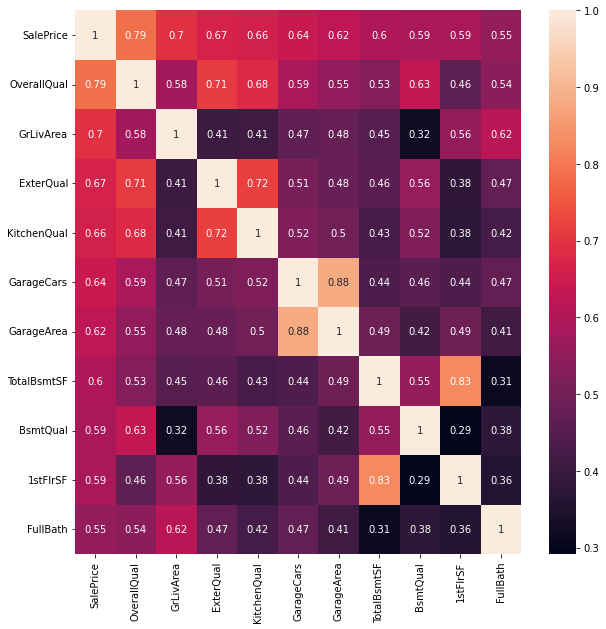

In [20]:
_, corr_mat = visualizer.corr_heatmap(yname='SalePrice', save_fig=True, filename='heatmap')
plt.show()

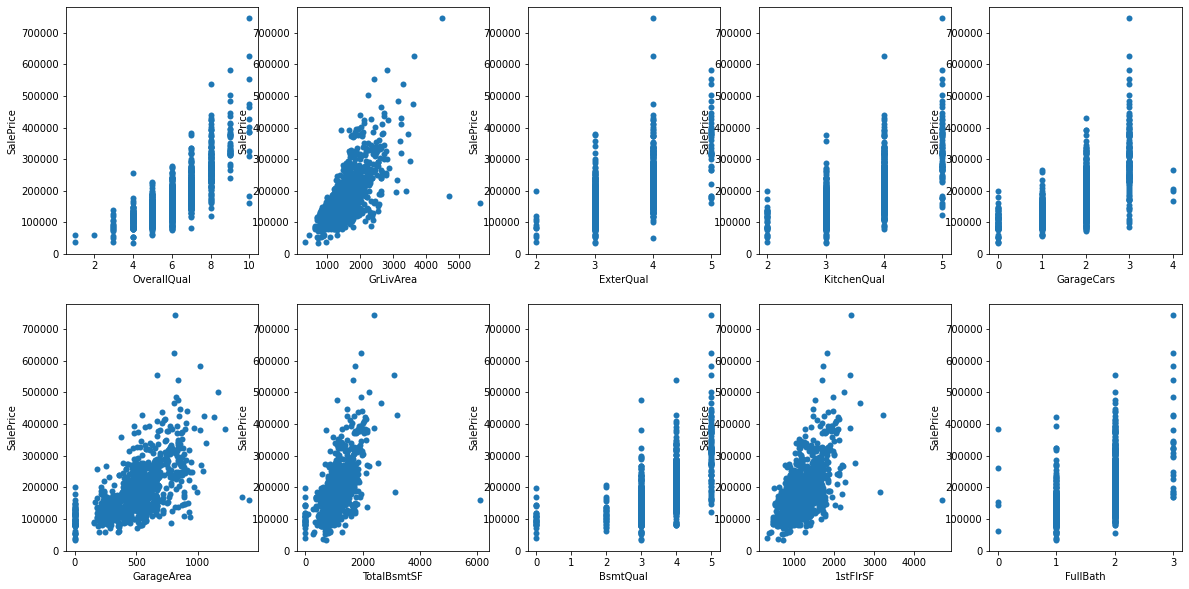

In [21]:
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axs = axs.flatten()

for i, feature in enumerate(corr_mat.columns[1:]):
    sns.scatterplot(data=df_train_cat2num, x=feature, y='SalePrice', ax=axs[i], linewidth=0)
plt.show()

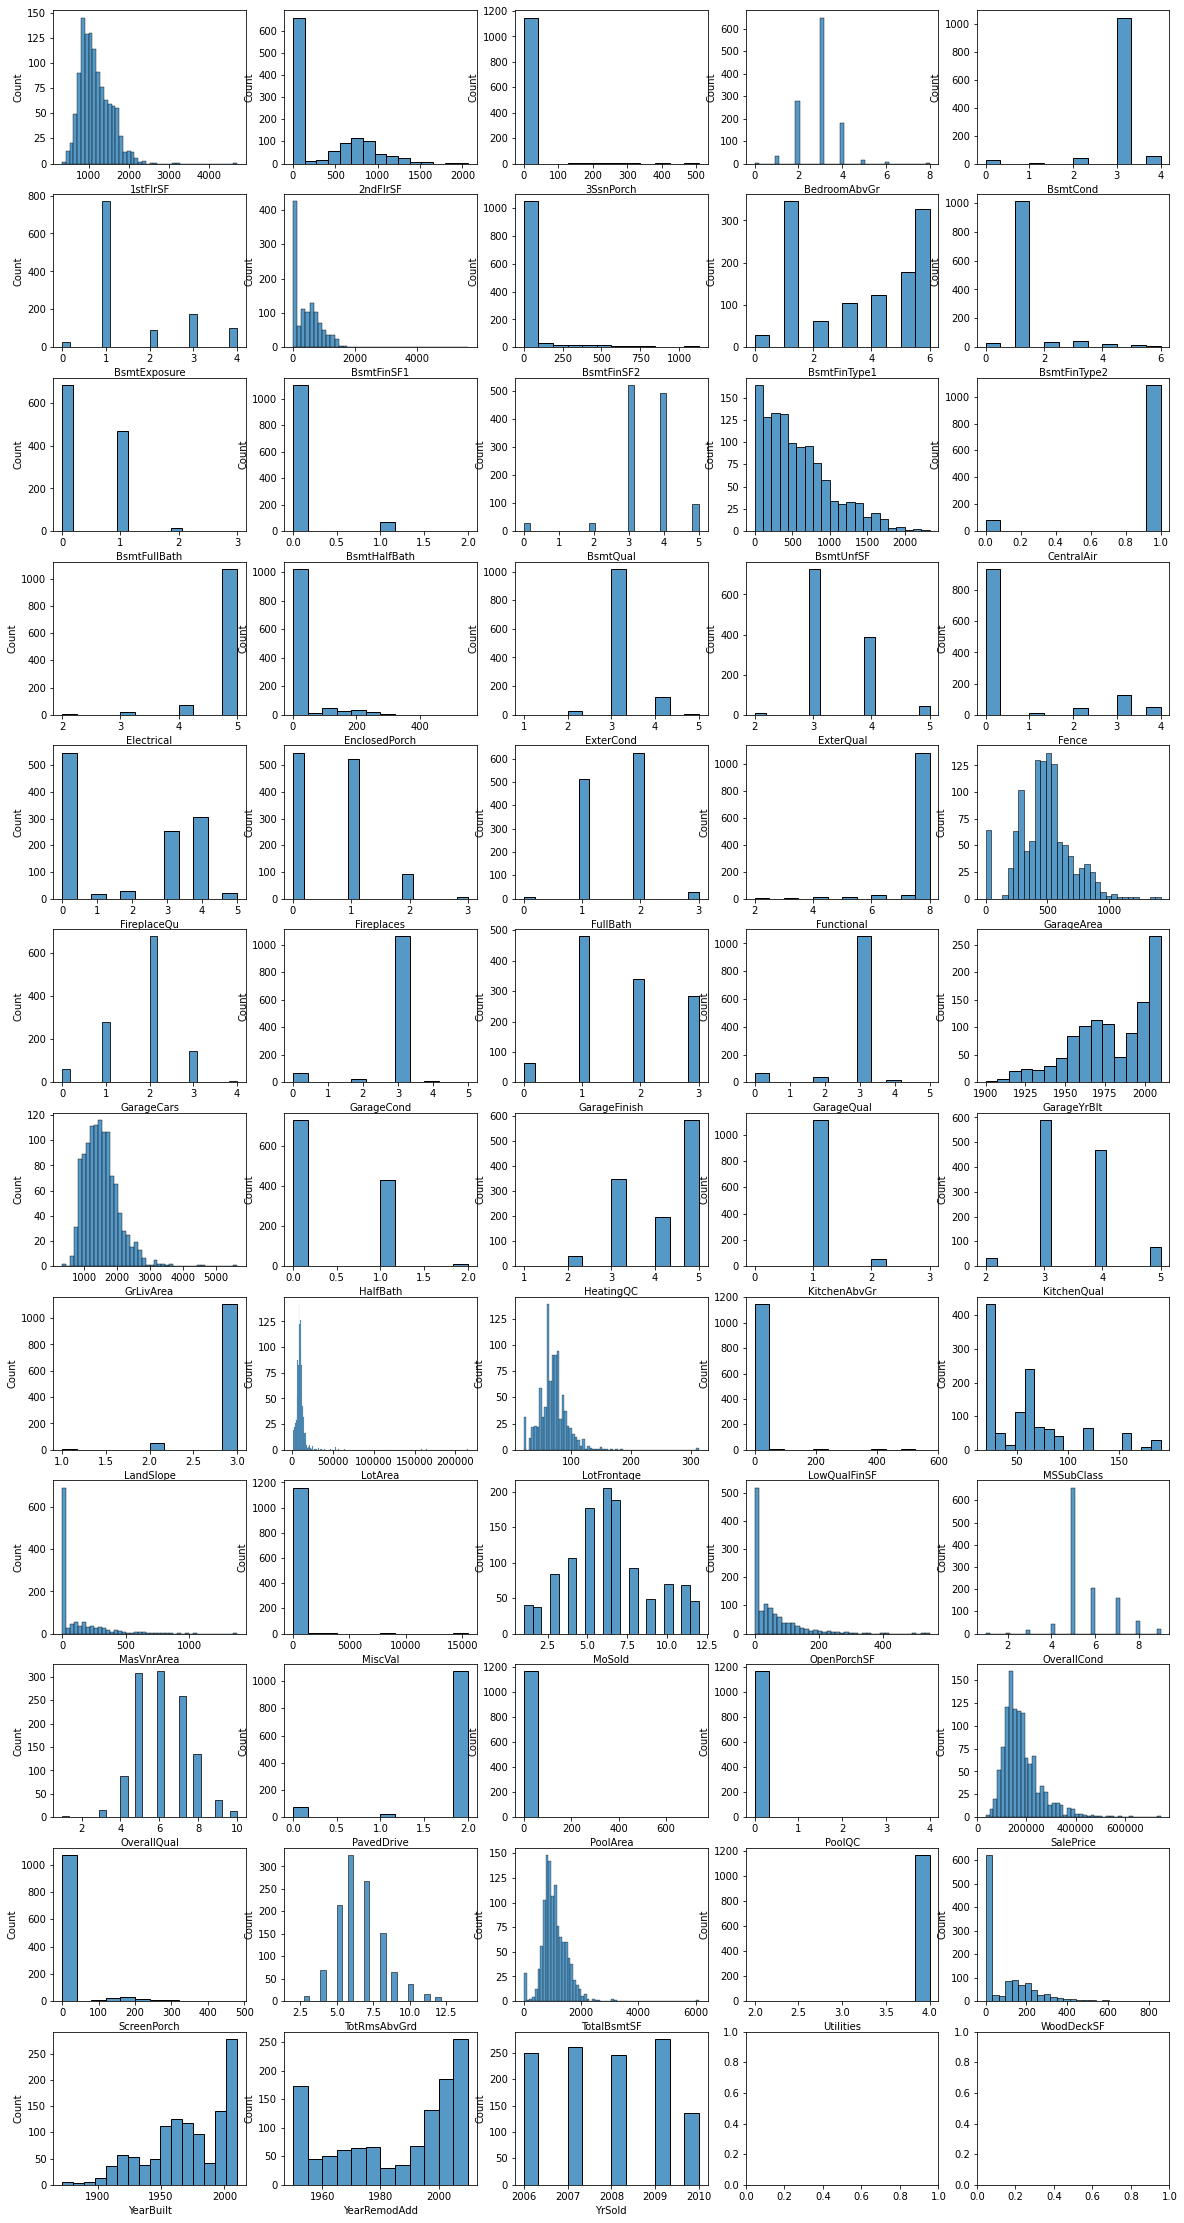

In [22]:
visualizer.visualize_num_attr(figsize=(20, 40), save_fig=True, filename='Num_attr_original')
plt.show()

In [23]:
num_attrs_no_info = ['3SsnPorch', 'BsmtFinSF2', 'BsmtHalfBath', 'CentralAir', 'Electrical',
                      'ExterCond', 'Functional', 'GarageCond', 'GarageQual', 'KitchenAbvGr',
                      'LandSlope', 'LowQualFinSF', 'MiscVal', 'PavedDrive', 'PoolArea', 
                      'PoolQC', 'ScreenPorch', 'Utilities', ]
cat_attrs_no_info  = ['Condition2', 'Heating', 'LandContour', 'RoofMatl', 'SaleType', 'Street']

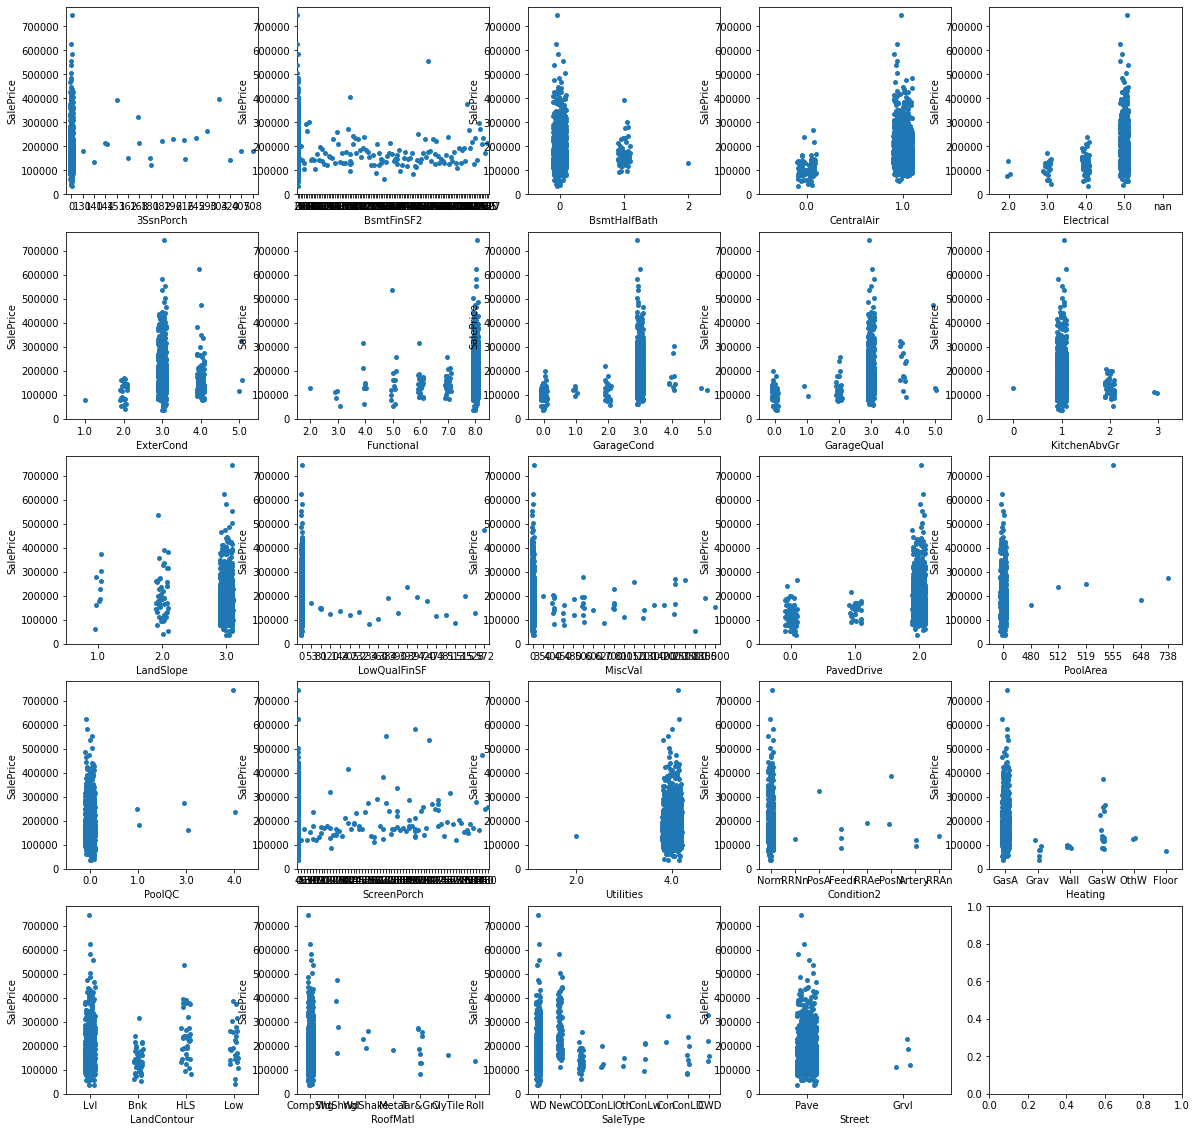

In [24]:
visualizer.plot_features(num_attrs_no_info + cat_attrs_no_info, yname='SalePrice',
                         save_fig=True, filename='Features_no_info')
plt.show()

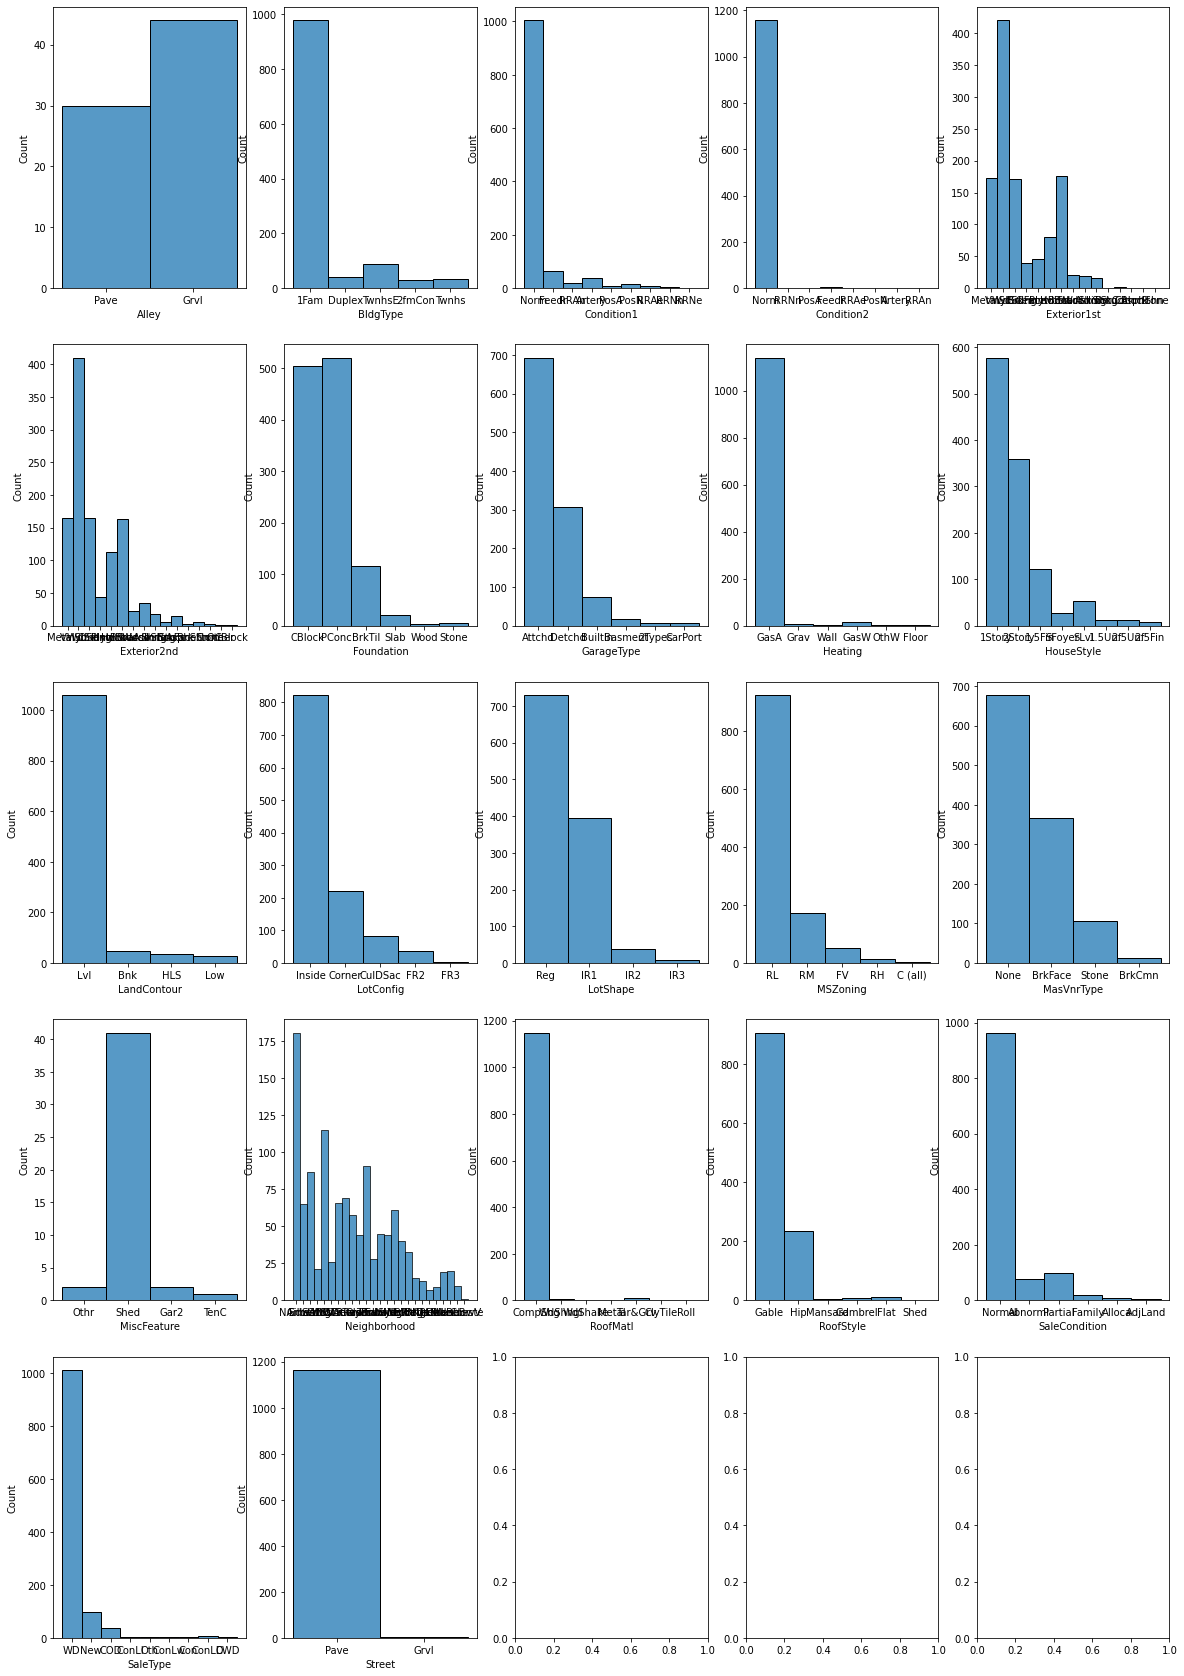

In [25]:
visualizer.visualize_cat_attr(figsize=(20, 30), save_fig=True, filename='Cat_attr_original')
plt.show()

## 2.3 Delete features with nearly no info

In [26]:
class NoInfoFeatureDeletor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X: pd.DataFrame):
        X = X.drop(num_attrs_no_info + cat_attrs_no_info, axis=1)
        return X

In [27]:
X_train_del_no_info= NoInfoFeatureDeletor().fit_transform(X_train_cat2num)
X_train_del_no_info

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LotConfig,Neighborhood,Condition1,BldgType,...,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,Fence,MiscFeature,MoSold,YrSold,SaleCondition
0,20,RL,70.0,8400,NaN,Reg,Inside,NAmes,Norm,1Fam,...,1,294,250,0,0,0.0,NaN,6,2010,Normal
1,60,RL,59.0,7837,NaN,IR1,Inside,Gilbert,Norm,1Fam,...,2,380,0,40,0,0.0,NaN,5,2009,Normal
2,30,RL,67.0,8777,NaN,Reg,Inside,Edwards,Feedr,1Fam,...,0,0,328,0,164,3.0,NaN,5,2008,Normal
3,50,RL,60.0,7200,NaN,Reg,Corner,SWISU,Feedr,1Fam,...,1,240,0,0,264,3.0,NaN,6,2007,Normal
4,50,RL,50.0,5000,Pave,Reg,Inside,SWISU,Norm,1Fam,...,1,308,0,0,242,0.0,NaN,5,2010,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,20,RL,78.0,9317,NaN,IR1,Inside,CollgCr,Norm,1Fam,...,2,440,0,22,0,0.0,NaN,3,2007,Normal
1164,50,RL,65.0,7804,NaN,Reg,Inside,SWISU,Norm,1Fam,...,2,576,431,44,0,3.0,NaN,12,2009,Normal
1165,20,RL,60.0,8172,NaN,Reg,Inside,Edwards,Norm,1Fam,...,2,572,0,0,0,0.0,NaN,4,2006,Normal
1166,50,RL,55.0,7642,NaN,Reg,Corner,Crawfor,Norm,1Fam,...,1,216,0,240,0,4.0,NaN,6,2007,Normal


## 2.4 Feature Combination and creation (To be done)

## 2.5 Check and impute missing values, encode categorical features

In [28]:
X_train_del_no_info.select_dtypes(object).isna().sum(axis=0).sort_values(ascending=False)

MiscFeature      1122
Alley            1094
GarageType         64
MasVnrType          6
MSZoning            0
LotShape            0
LotConfig           0
Neighborhood        0
Condition1          0
BldgType            0
HouseStyle          0
RoofStyle           0
Exterior1st         0
Exterior2nd         0
Foundation          0
SaleCondition       0
dtype: int64

In [29]:
X_train_del_no_info.select_dtypes(np.number).isna().sum(axis=0).sort_values(ascending=False)

LotFrontage      217
GarageYrBlt       64
MasVnrArea         6
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenQual        0
TotRmsAbvGrd       0
Fireplaces         0
FireplaceQu        0
MSSubClass         0
BsmtFullBath       0
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
Fence              0
MoSold             0
GarageFinish       0
2ndFlrSF           0
GrLivArea          0
1stFlrSF           0
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
ExterQual          0
BsmtQual           0
BsmtCond           0
BsmtExposure       0
BsmtFinType1       0
BsmtFinSF1         0
BsmtFinType2       0
BsmtUnfSF          0
TotalBsmtSF        0
HeatingQC          0
YrSold             0
dtype: int64

array([<AxesSubplot:xlabel='MiscFeature', ylabel='SalePrice'>,
       <AxesSubplot:xlabel='Alley', ylabel='SalePrice'>], dtype=object)

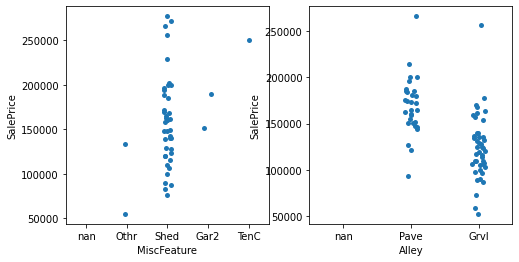

In [30]:
nan_features = ['MiscFeature', 'Alley']
visualizer.plot_features(nan_features, yname='SalePrice', ncols=2)

### 2.5.1 Delete feature with too many NaNs

In [31]:
class NanFeatureDeletor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X: pd.DataFrame):
        X = X.drop(nan_features, axis=1)
        return X

In [32]:
X_train_del_nan_feature = NanFeatureDeletor().fit_transform(X_train_del_no_info)
X_train_del_nan_feature

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,...,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,Fence,MoSold,YrSold,SaleCondition
0,20,RL,70.0,8400,Reg,Inside,NAmes,Norm,1Fam,1Story,...,2.0,1,294,250,0,0,0.0,6,2010,Normal
1,60,RL,59.0,7837,IR1,Inside,Gilbert,Norm,1Fam,2Story,...,2.0,2,380,0,40,0,0.0,5,2009,Normal
2,30,RL,67.0,8777,Reg,Inside,Edwards,Feedr,1Fam,1Story,...,0.0,0,0,328,0,164,3.0,5,2008,Normal
3,50,RL,60.0,7200,Reg,Corner,SWISU,Feedr,1Fam,1.5Fin,...,1.0,1,240,0,0,264,3.0,6,2007,Normal
4,50,RL,50.0,5000,Reg,Inside,SWISU,Norm,1Fam,1.5Fin,...,1.0,1,308,0,0,242,0.0,5,2010,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,20,RL,78.0,9317,IR1,Inside,CollgCr,Norm,1Fam,1Story,...,2.0,2,440,0,22,0,0.0,3,2007,Normal
1164,50,RL,65.0,7804,Reg,Inside,SWISU,Norm,1Fam,1.5Fin,...,1.0,2,576,431,44,0,3.0,12,2009,Normal
1165,20,RL,60.0,8172,Reg,Inside,Edwards,Norm,1Fam,1Story,...,1.0,2,572,0,0,0,0.0,4,2006,Normal
1166,50,RL,55.0,7642,Reg,Corner,Crawfor,Norm,1Fam,1.5Fin,...,1.0,1,216,0,240,0,4.0,6,2007,Normal


### 2.5.2 OneHotEncoder for categorical values

In [33]:
class CatAttrEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X: pd.DataFrame, y=None):
        encoder = OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist',
                                min_frequency=0.05, sparse=False)
        self.transformer = ColumnTransformer(
            [('Num', 'passthrough', make_column_selector(dtype_include=np.number)),
             ('Cat', encoder, make_column_selector(dtype_include=object))],
        )
        self.transformer.fit(X)
        return self
    
    def transform(self, X: pd.DataFrame):
        return pd.DataFrame(self.transformer.transform(X),
                            columns=self.transformer.get_feature_names_out())
        
        

In [34]:
X_train_one_hot = CatAttrEncoder().fit_transform(X_train_del_nan_feature)
X_train_one_hot

,Num__MSSubClass,Num__LotFrontage,Num__LotArea,Num__OverallQual,Num__OverallCond,Num__YearBuilt,Num__YearRemodAdd,Num__MasVnrArea,Num__ExterQual,Num__BsmtQual,...,Cat__Foundation_CBlock,Cat__Foundation_PConc,Cat__Foundation_infrequent_sklearn,Cat__GarageType_BuiltIn,Cat__GarageType_Detchd,Cat__GarageType_nan,Cat__GarageType_infrequent_sklearn,Cat__SaleCondition_Normal,Cat__SaleCondition_Partial,Cat__SaleCondition_infrequent_sklearn
0,20.0,70.0,8400.0,5.0,6.0,1957.0,1957.0,0.0,3.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,60.0,59.0,7837.0,6.0,7.0,1993.0,1994.0,0.0,4.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,30.0,67.0,8777.0,5.0,7.0,1910.0,1950.0,0.0,3.0,2.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,50.0,60.0,7200.0,5.0,7.0,1937.0,1950.0,252.0,3.0,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,50.0,50.0,5000.0,5.0,6.0,1924.0,1950.0,0.0,3.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,20.0,78.0,9317.0,6.0,5.0,2006.0,2006.0,0.0,4.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1164,50.0,65.0,7804.0,4.0,3.0,1928.0,1950.0,0.0,3.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1165,20.0,60.0,8172.0,5.0,7.0,1955.0,1990.0,0.0,3.0,3.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1166,50.0,55.0,7642.0,7.0,8.0,1918.0,1998.0,0.0,4.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### 2.5.3 Impute missing values by KNNImputer

In [35]:
class MissingValImputer(BaseEstimator, TransformerMixin):
    def fit(self, X: pd.DataFrame, y=None):
        
        self.scaler = StandardScaler()
        self.imputer = KNNImputer(n_neighbors=5, weights='distance')
        self.imputer.fit(self.scaler.fit_transform(X))
        return self
    
    def transform(self, X: pd.DataFrame):
        return pd.DataFrame(self.scaler.inverse_transform(
                                self.imputer.transform(self.scaler.transform(X))),
                            columns=X.columns)

In [36]:
mvi = MissingValImputer()
X_train_imputed = mvi.fit_transform(X_train_one_hot)
X_train_imputed

,Num__MSSubClass,Num__LotFrontage,Num__LotArea,Num__OverallQual,Num__OverallCond,Num__YearBuilt,Num__YearRemodAdd,Num__MasVnrArea,Num__ExterQual,Num__BsmtQual,...,Cat__Foundation_CBlock,Cat__Foundation_PConc,Cat__Foundation_infrequent_sklearn,Cat__GarageType_BuiltIn,Cat__GarageType_Detchd,Cat__GarageType_nan,Cat__GarageType_infrequent_sklearn,Cat__SaleCondition_Normal,Cat__SaleCondition_Partial,Cat__SaleCondition_infrequent_sklearn
0,20.0,70.0,8400.0,5.0,6.0,1957.0,1957.0,0.0,3.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-3.469447e-18
1,60.0,59.0,7837.0,6.0,7.0,1993.0,1994.0,0.0,4.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-3.469447e-18
2,30.0,67.0,8777.0,5.0,7.0,1910.0,1950.0,0.0,3.0,2.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-3.469447e-18
3,50.0,60.0,7200.0,5.0,7.0,1937.0,1950.0,252.0,3.0,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-3.469447e-18
4,50.0,50.0,5000.0,5.0,6.0,1924.0,1950.0,0.0,3.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-3.469447e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,20.0,78.0,9317.0,6.0,5.0,2006.0,2006.0,0.0,4.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-3.469447e-18
1164,50.0,65.0,7804.0,4.0,3.0,1928.0,1950.0,0.0,3.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-3.469447e-18
1165,20.0,60.0,8172.0,5.0,7.0,1955.0,1990.0,0.0,3.0,3.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-3.469447e-18
1166,50.0,55.0,7642.0,7.0,8.0,1918.0,1998.0,0.0,4.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-3.469447e-18


## 2.6 Preprocessing pipeline

In [37]:
pipe_preprocess = make_pipeline(
    Cat2NumTransformer(),
    NoInfoFeatureDeletor(),
    NanFeatureDeletor(),
    CatAttrEncoder(),
    MissingValImputer()
)
pipe_preprocess

Pipeline(steps=[('cat2numtransformer', Cat2NumTransformer()),
                ('noinfofeaturedeletor', NoInfoFeatureDeletor()),
                ('nanfeaturedeletor', NanFeatureDeletor()),
                ('catattrencoder', CatAttrEncoder()),
                ('missingvalimputer', MissingValImputer())])

In [38]:
X_train_preprocessed = pipe_preprocess.fit_transform(X_train)
X_train_preprocessed

,Num__MSSubClass,Num__LotFrontage,Num__LotArea,Num__OverallQual,Num__OverallCond,Num__YearBuilt,Num__YearRemodAdd,Num__MasVnrArea,Num__ExterQual,Num__BsmtQual,...,Cat__Foundation_CBlock,Cat__Foundation_PConc,Cat__Foundation_infrequent_sklearn,Cat__GarageType_BuiltIn,Cat__GarageType_Detchd,Cat__GarageType_nan,Cat__GarageType_infrequent_sklearn,Cat__SaleCondition_Normal,Cat__SaleCondition_Partial,Cat__SaleCondition_infrequent_sklearn
0,20.0,70.0,8400.0,5.0,6.0,1957.0,1957.0,0.0,3.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-3.469447e-18
1,60.0,59.0,7837.0,6.0,7.0,1993.0,1994.0,0.0,4.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-3.469447e-18
2,30.0,67.0,8777.0,5.0,7.0,1910.0,1950.0,0.0,3.0,2.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-3.469447e-18
3,50.0,60.0,7200.0,5.0,7.0,1937.0,1950.0,252.0,3.0,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-3.469447e-18
4,50.0,50.0,5000.0,5.0,6.0,1924.0,1950.0,0.0,3.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-3.469447e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,20.0,78.0,9317.0,6.0,5.0,2006.0,2006.0,0.0,4.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-3.469447e-18
1164,50.0,65.0,7804.0,4.0,3.0,1928.0,1950.0,0.0,3.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-3.469447e-18
1165,20.0,60.0,8172.0,5.0,7.0,1955.0,1990.0,0.0,3.0,3.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-3.469447e-18
1166,50.0,55.0,7642.0,7.0,8.0,1918.0,1998.0,0.0,4.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-3.469447e-18


# 3. Model Building and testing

In [39]:
model_saver = ModelSaver()

## 3.1 Linear Models

### 3.1.1 Linear regression and diagnostics with statsmodels

In [40]:
lin_reg_diag = LinRegDiagnostics(sm.add_constant(X_train_preprocessed), y_train)

/Users/l/.pyenv/versions/3.9.7/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


<AxesSubplot:xlabel='Theoretical Quantiles', ylabel='Sample Quantiles'>

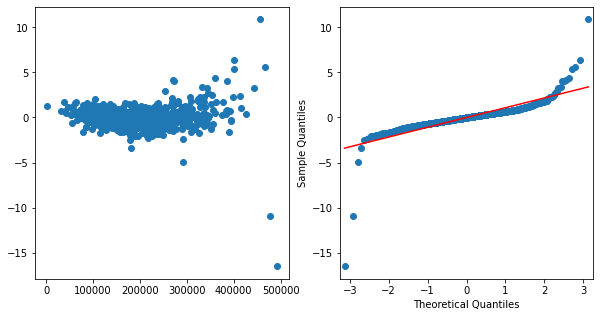

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

lin_reg_diag.resid_vs_fitted(ax=ax[0])
lin_reg_diag.qqplot(ax=ax[1])

In [42]:
vif_series = lin_reg_diag.vif_series()

In [43]:
vif_series

const                                 2.657780e+06
Num__GrLivArea                        1.441847e+02
Num__2ndFlrSF                         1.106570e+02
Num__1stFlrSF                         8.332293e+01
Cat__Exterior2nd_VinylSd              3.189830e+01
                                          ...     
Num__Fence                            1.240636e+00
Cat__RoofStyle_infrequent_sklearn     1.185870e+00
Num__YrSold                           1.128493e+00
Cat__MasVnrType_infrequent_sklearn    1.127905e+00
Num__MoSold                           1.089583e+00
Length: 87, dtype: float64

<AxesSubplot:>

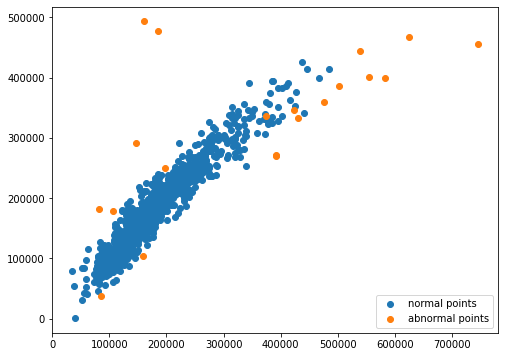

In [44]:
lin_reg_diag.plot_abnomral(lin_reg_diag.ols_influence.dffits[0], abs_flag=True,
                           n_points=20)

In [45]:
X_new, y_new = lin_reg_diag.get_X_y_truncated(lin_reg_diag.ols_influence.dffits[0], abs_flag=True,
                                            n_drop=20)

In [46]:
diag2 = LinRegDiagnostics(X_new, y_new)

/Users/l/.pyenv/versions/3.9.7/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


<AxesSubplot:>

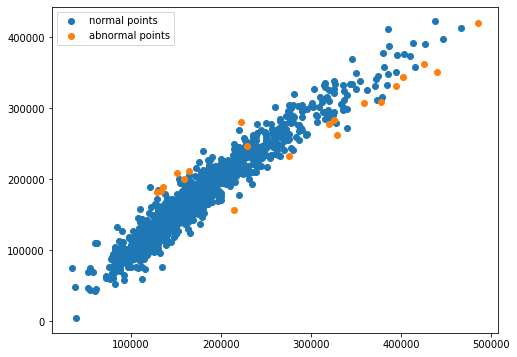

In [47]:
diag2.plot_abnomral(diag2.ols_influence.dffits[0], abs_flag=True,
                    n_points=20)

### 3.1.2 OLS, Ridge, Lasso, and ElasticNet

In [48]:
# OLS
lin_reg = TransformedTargetRegressor(
    regressor=LinearRegression(),
    func=np.log1p,
    inverse_func=np.expm1,
)
lin_reg.fit(X_train_preprocessed, y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=LinearRegression())

In [49]:
# Ridge
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
ridge = Pipeline(
    [('Scaler', StandardScaler()),
     ('Ridge', TransformedTargetRegressor(
        regressor=RidgeCV(alphas=[0.1, 0.5, 1, 2, 10, 20],
                          scoring='neg_root_mean_squared_error',
                          cv=kfold),
        func=np.log1p,
        inverse_func=np.expm1,
     ))]
) 
ridge.fit(X_train_preprocessed, y_train)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('Ridge',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=RidgeCV(alphas=[0.1, 0.5,
                                                                      1, 2, 10,
                                                                      20],
                                                              cv=KFold(n_splits=5, random_state=42, shuffle=True),
                                                              scoring='neg_root_mean_squared_error')))])

In [50]:
# Lasso
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
lasso = Pipeline(
    [('Scaler', StandardScaler()),
     ('Lasso', TransformedTargetRegressor(
        regressor=LassoCV(cv=kfold),
        func=np.log1p,
        inverse_func=np.expm1,
     ))]
) 
lasso.fit(X_train_preprocessed, y_train)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('Lasso',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=LassoCV(cv=KFold(n_splits=5, random_state=42, shuffle=True))))])

In [94]:
# ElasticNet
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
elastic_net = Pipeline(
    [('Scaler', StandardScaler()),
     ('Elastic_net', TransformedTargetRegressor(
        regressor=ElasticNetCV(cv=kfold),
        func=np.log1p,
        inverse_func=np.expm1,
     ))]
) 
elastic_net.fit(X_train_preprocessed, y_train)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('Elastic_net',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=ElasticNetCV(cv=KFold(n_splits=5, random_state=42, shuffle=True))))])

## 3.2 SVM models

In [95]:
# LinearSVR
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
lin_svr = LinearSVR()
param_grid_lin_svr = {
    
}

## 3.3 KNN

In [96]:
# KNN
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
knn_model = KNeighborsRegressor()
param_grid_knn = {
    'n_neighbors': [3, 5, 10],
    'weights': ['uniform', 'distance']
}
knn = GridSearchCV(knn_model, param_grid_knn, scoring='neg_root_mean_squared_error',
                   cv=kfold)
knn.fit(X_train_preprocessed, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [3, 5, 10],
                         'weights': ['uniform', 'distance']},
             scoring='neg_root_mean_squared_error')

## 3.4 Tree Models

### 3.4.1 Decision Tree

In [109]:
# Decision Tree
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
decision_tree_model = DecisionTreeRegressor(random_state=42)
param_grid_decision_tree = {
    'max_depth': [10, 20, 50],
    'min_samples_split': [2, 5, 10, 20, 50],
    'max_features': [None, 0.2, 0.4, 0.6],
    'min_samples_leaf': [1, 5, 10]
}
decision_tree = GridSearchCV(decision_tree_model, param_grid_decision_tree,
                             scoring='neg_root_mean_squared_error', cv=kfold)
decision_tree.fit(X_train_preprocessed, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [10, 20, 50],
                         'max_features': [None, 0.2, 0.4, 0.6],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 5, 10, 20, 50]},
             scoring='neg_root_mean_squared_error')

In [103]:
decision_tree.best_params_

{'max_depth': 10,
 'max_features': 0.6,
 'min_samples_leaf': 5,
 'min_samples_split': 20}

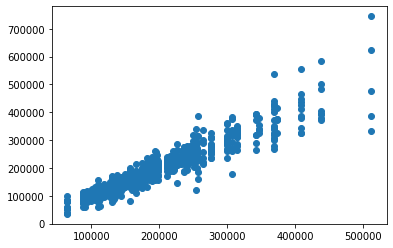

In [104]:
plt.scatter(decision_tree.predict(X_train_preprocessed), y_train)

### 3.4.2 Gradient Boosting

In [107]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
gbr_model = GradientBoostingRegressor(random_state=42)
param_grid_gbr = {
    'learning_rate': [0.1, 0.2, 0.5],
    'n_estimators': [50, 100, 200],
    'subsample': [0.2, 0.5, 1.0],
    'max_depth': [3, 6],
    'max_features': [0.2, 0.5, None],   
}
gbr = GridSearchCV(gbr_model, param_grid_gbr,
                   scoring='neg_root_mean_squared_error',
                   cv=kfold)
gbr.fit(X_train_preprocessed, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.1, 0.2, 0.5], 'max_depth': [3, 6],
                         'max_features': [0.2, 0.5, None],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.2, 0.5, 1.0]},
             scoring='neg_root_mean_squared_error')

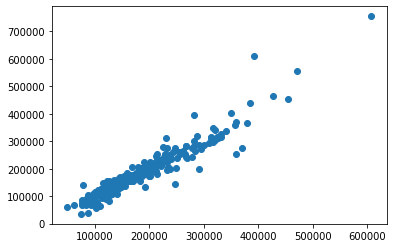

In [111]:
plt.scatter(gbr.predict(pipe_preprocess.transform(X_test)), y_test)

In [116]:
s = (pd.Series(gbr.best_estimator_.feature_importances_, index=X_train_preprocessed.columns)
        .sort_values(ascending=False))
s

Num__OverallQual            0.210382
Num__GrLivArea              0.111852
Num__TotalBsmtSF            0.078189
Num__2ndFlrSF               0.076243
Num__GarageFinish           0.043766
                              ...   
Cat__Condition1_Feedr       0.000000
Cat__BldgType_2fmCon        0.000000
Cat__HouseStyle_SFoyer      0.000000
Cat__BldgType_Duplex        0.000000
Cat__Neighborhood_IDOTRR    0.000000
Length: 106, dtype: float64

### 3.4.3 Random Forest

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
rf_model = RandomForestRegressor(random_state=42)
param_grid_gbr = {
    'learning_rate': [0.1, 0.2, 0.5],
    'n_estimators': [50, 100, 200],
    'subsample': [0.2, 0.5, 1.0],
    'max_depth': [3, 6],
    'max_features': [0.2, 0.5, None],   
}
gbr = GridSearchCV(gbr_model, param_grid_gbr,
                   scoring='neg_root_mean_squared_error',
                   cv=kfold)
gbr.fit(X_train_preprocessed, y_train)

# 4. Classification

In [101]:
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [71]:
y_train_cat = pd.qcut(y_train, np.linspace(0, 1, 6), labels=range(1, 6)).astype(np.int32)
y_train_cat
y_train_cat2 = y_train_cat.replace({i: j for i, j in zip(range(1, 6), 'abcde')})

## 4.1 Ridge Classifier

In [72]:
ridge_clf = RidgeClassifier().fit(X_train_preprocessed, y_train_cat2)

In [73]:
ridge_clf.classes_

array(['a', 'b', 'c', 'd', 'e'], dtype='<U1')

In [75]:
ridge_clf.decision_function(X_train_preprocessed)

array([[-0.37887563, -0.13841937, -0.56919685, -0.79350428, -1.12000387],
       [-1.05453328, -0.85710576, -0.00470681, -0.09801497, -0.98563918],
       [ 0.75994475, -0.64290094, -0.68343235, -1.29202804, -1.14158342],
       ...,
       [-0.21211291, -0.07505612, -0.88153399, -1.06183885, -0.76945814],
       [-0.6411759 , -0.43049199, -0.54548901, -0.8217602 , -0.56108289],
       [-1.12777791, -0.74660808, -0.30813803, -0.52198378, -0.2954922 ]])

In [76]:
ridge_clf.predict(X_train_preprocessed)

array(['b', 'c', 'a', ..., 'b', 'b', 'e'], dtype='<U1')

In [100]:
ridge_clf.score(X_train_preprocessed, y_train_cat2)

0.6815068493150684

## 4.2 LogisticRegression

In [95]:
logit_reg = LogisticRegression()
logit_reg.fit(X_train_preprocessed, y_train_cat2)

/Users/l/.pyenv/versions/3.9.7/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1000, max_iter=1000)

In [86]:
logit_reg.predict(X_train_preprocessed)

array(['b', 'c', 'a', ..., 'a', 'a', 'd'], dtype=object)

In [99]:
logit_reg.score(X_train_preprocessed, y_train_cat2)

0.6481164383561644

## 4.3 LDA and QDA

In [104]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_preprocessed, y_train_cat2)

LinearDiscriminantAnalysis()

In [105]:
lda.score(X_train_preprocessed, y_train_cat2)

0.7559931506849316

In [106]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_preprocessed, y_train_cat2)

/Users/l/.pyenv/versions/3.9.7/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis()

In [107]:
qda.score(X_train_preprocessed, y_train_cat2)

0.5291095890410958

## 4.4 Tree

In [117]:
print(lin_reg_diag.ols_res.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     74.66
Date:                Tue, 29 Nov 2022   Prob (F-statistic):               0.00
Time:                        23:59:45   Log-Likelihood:                -13671.
No. Observations:                1168   AIC:                         2.752e+04
Df Residuals:                    1081   BIC:                         2.796e+04
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------